In [147]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

import time

## some examples of how to read data and downsize

In [148]:
#hdulist = fits.open('/Volumes/NO NAME/Maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits')  # <-- Gemma's testing file path
hdulist = fits.open('/Volumes/WTL/convergence_maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits')  # <-- Tianli's testing file path
hdulist.info()

Filename: /Volumes/WTL/convergence_maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (1024, 1024)   float32   


In [149]:
hdudata = hdulist[0]
data = hdudata.data 

In [150]:
hdudata.shape

(1024, 1024)

In [151]:
hdudata.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
ANGLE   =                  3.5 / angle of the map in degrees                    

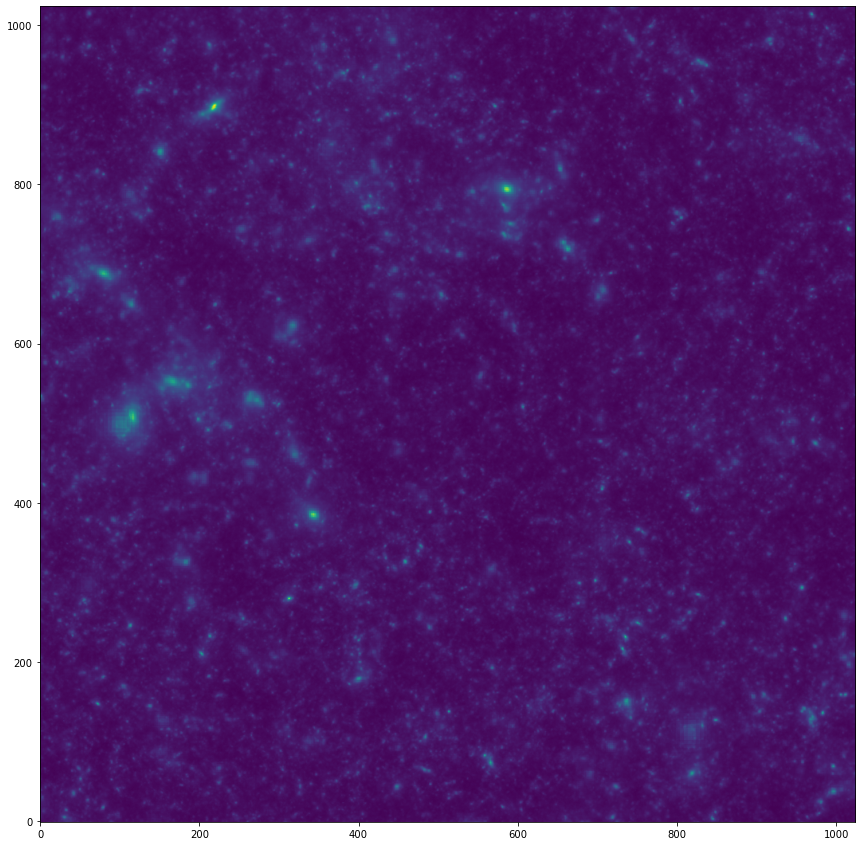

In [152]:
matplotlib.rcParams['figure.figsize'] = [15, 15]  # just to change the plot size when we need to (here only trying to see how the size of the structures on the map compare to the pixel size after downsizing two cells later)
plt.imshow(hdudata.data, origin='lower')

In [153]:
# example of how to downsize 

l_original = int(data.shape[0])
l_downsized = int(l_original/2)
image_downsized = data.reshape([l_downsized, l_original//l_downsized, 
                                l_downsized, l_original//l_downsized]).mean(3).mean(1)
l_downsized_2 = int(l_original/4)
image_downsized_2 = data.reshape([l_downsized_2, l_original//l_downsized_2, 
                                l_downsized_2, l_original//l_downsized_2]).mean(3).mean(1)

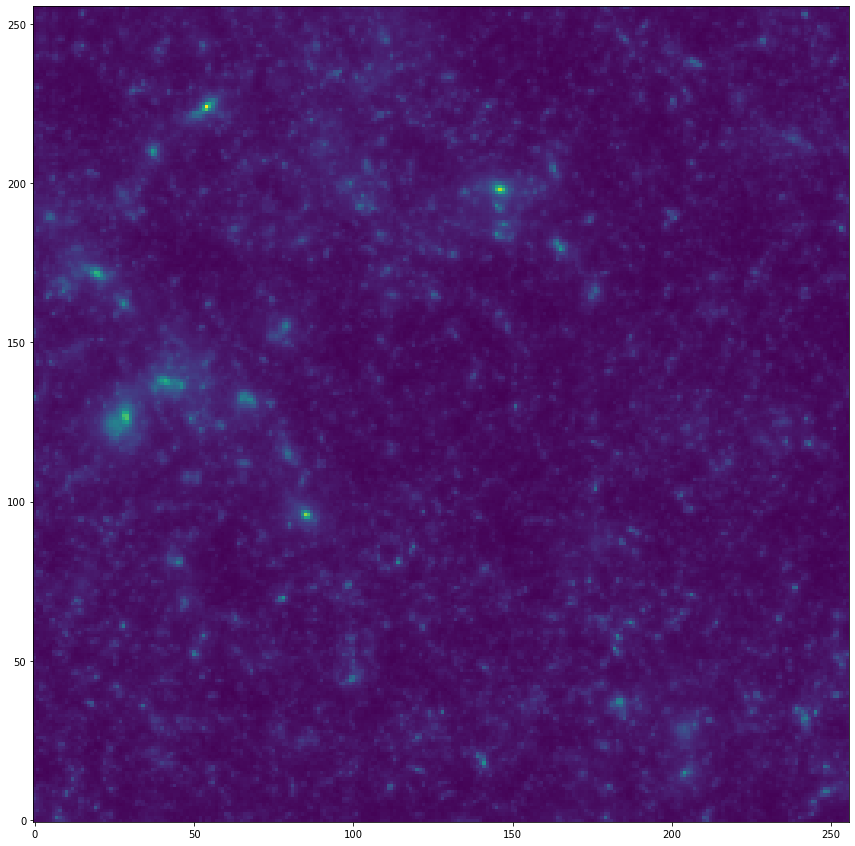

In [154]:
plt.imshow(image_downsized_2, origin='lower')

## Actual code for the network starts below

In [155]:
# read files 

# add your file path into rootpath before you proceed 
rootpath = '/Volumes/WTL/convergence_maps/Om0.183_si0.958/'  # <-- Tianli's testing file path
#rootpath = '/Volumes/NO NAME/Maps/Om0.183_si0.958/' <-- Gemma's testing file path

# these parameters are inherent to the image data 
n_imagespercosmo = 512  # number of images per cosmology 
n_perbatch = 32         # batch size
n_batch = n_imagespercosmo/n_perbatch  # number of minibatches 
dim_image = 1024 
dim_downsized = int(dim_image/2)            # downsized image dimension 


# read in the files and put them into 3D matrix 
inputs = []

start_time = time.time()  # time loading files

#for i in range(1, 51): 
for i in range(1, n_imagespercosmo+1): 
    if (i < 10): filenum = '00{}'.format(i)
    elif (i < 100): filenum = '0{}'.format(i)
    else: filenum = i
    
    hdulist = fits.open('{}WLconv_z1.00_0{}r.fits'.format(rootpath, filenum))
    image = hdulist[0].data
    
    # downsize from dim_image to dim_downsized 
    image_downsized = image.reshape([dim_downsized, dim_image//dim_downsized, 
                                dim_downsized, dim_image//dim_downsized]).mean(3).mean(1)
    
    # newaxis makes the image 3D (1x512x512) 
    inputs.append(image_downsized[np.newaxis,:,:])

print("--- Time to load the files: %s seconds ---" % (time.time() - start_time))

--- Time to load the files: 83.22106504440308 seconds ---


In [156]:
# break the data into batches  

#n_perbatch = 5  # this is a temp testing value to replace the default 32 per batch
target = torch.tensor([0.183, 0.958]).repeat(n_perbatch, 1)  # target value of sigma8 and omegam (stacked to the correct dimension to match the number per batch)

# make the data into 4D tensor and put each batch into iterable 
trainloader = torch.utils.data.DataLoader(np.array(inputs), batch_size=n_perbatch, shuffle=False)
train = iter(trainloader)

In [157]:
# network structure 

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool2 = nn.AvgPool2d(2, 2)
        self.pool4 = nn.AvgPool2d(4, 4)
        self.pool6 = nn.AvgPool2d(6, 6)
        
        self.conv1to32_5 = nn.Conv2d(1, 32, 5)
        self.conv32to64_5 = nn.Conv2d(32, 64, 5)
        self.conv64to128_5 = nn.Conv2d(64, 128, 5)
        self.conv128to256_5 = nn.Conv2d(128, 256, 5)
        self.conv256to512_5 = nn.Conv2d(256, 512, 5)
        self.conv512to256_5 = nn.Conv2d(512, 216, 5)
        self.conv256to512_3 = nn.Conv2d(216, 512, 3)
        
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1to32_5(x)))  # out: 254x254x32 
        x = self.pool2(F.relu(self.conv32to64_5(x)))  # out: 125x125x64 
        x = self.pool2(F.relu(self.conv64to128_5(x)))  # out: 60x60x128 
        x = self.pool2(F.relu(self.conv128to256_5(x)))  # out: 28x28x256 
        x = self.pool2(F.relu(self.conv256to512_5(x)))  # out: 12x12x512
        x = F.relu(self.conv512to256_5(x))  # out: 8x8x256 
        x = self.pool6(F.relu(self.conv256to512_3(x)))  # out: 6x6x512->1x1x512
        
        x = x.view(-1, 512)
        x = self.fc(x)
        return x
    
net = Net()

In [158]:
# loss function and training rate defined by paper 
criterion = nn.MSELoss()  # Did they use the MAE of two the params in paper?
optimizer = optim.SGD(net.parameters(), lr=0.005)

In [ ]:
start_time = time.time()  # to time the training

for epoch in range(10): 
    running_loss = 0.0 
    
    for i, data in enumerate(trainloader, 0):  
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        # .item() converts the tensor to a numpy number
#        running_loss += loss.item()
         
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))   # Changed running_loss to loss.item()  (1101w)

print("--- Training time: %s seconds ---" % (time.time() - start_time))

for layer in net.children():     # resetting the parameters in all the layers
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

[1,     1] loss: 0.459
[1,     2] loss: 0.453
[1,     3] loss: 0.447
[1,     4] loss: 0.442
[1,     5] loss: 0.436
[1,     6] loss: 0.431
[1,     7] loss: 0.426
[1,     8] loss: 0.420
[1,     9] loss: 0.415
[1,    10] loss: 0.410
[1,    11] loss: 0.405
[1,    12] loss: 0.400
[1,    13] loss: 0.395
[1,    14] loss: 0.390
[1,    15] loss: 0.385
[1,    16] loss: 0.380
[2,     1] loss: 0.376
[2,     2] loss: 0.371
[2,     3] loss: 0.366
[2,     4] loss: 0.362
[2,     5] loss: 0.357
[2,     6] loss: 0.353
[2,     7] loss: 0.349
[2,     8] loss: 0.344
[2,     9] loss: 0.340
[2,    10] loss: 0.336
[2,    11] loss: 0.332
[2,    12] loss: 0.328
[2,    13] loss: 0.324
[2,    14] loss: 0.320
[2,    15] loss: 0.316
[2,    16] loss: 0.312
[3,     1] loss: 0.308
[3,     2] loss: 0.304
[3,     3] loss: 0.300
[3,     4] loss: 0.297
[3,     5] loss: 0.293
[3,     6] loss: 0.289
[3,     7] loss: 0.286
[3,     8] loss: 0.282
[3,     9] loss: 0.279
[3,    10] loss: 0.275
[3,    11] loss: 0.272
[3,    12] 

## Testing the NN

In [ ]:
# read testing files (nothing really changed so far from reading training files)

#rootpath = '/Volumes/WTL/convergence_maps/Om0.183_si0.958/'  # <-- Tianli's testing file path; using the same as the training maps now
rootpath = '/Volumes/WTL/convergence_maps/Om0.183_si0.958/'
#rootpath = '/Volumes/NO NAME/Maps/Om0.183_si0.958/' <-- Gemma's testing file path

# these parameters are inherent to the image data; only kept for possibly changing n_perbatch at some point
n_imagespercosmo = 512  # number of images per cosmology 
n_perbatch = 32         # batch size
n_batch = n_imagespercosmo/n_perbatch  # number of minibatches 
dim_image = 1024 
dim_downsized = int(dim_image/2)            # downsized image dimension 


# read in the files and put them into 3D matrix 
inputs = []

for i in range(1, 51): 
    if (i < 10): filenum = '00{}'.format(i)
    elif (i < 100): filenum = '0{}'.format(i)
    else: filenum = i
    
    hdulist = fits.open('{}WLconv_z1.00_0{}r.fits'.format(rootpath, filenum))
    image = hdulist[0].data
    
    # downsize from dim_image to dim_downsized 
    image_downsized = image.reshape([dim_downsized, dim_image//dim_downsized, 
                                dim_downsized, dim_image//dim_downsized]).mean(3).mean(1)
    
    # newaxis makes the image 3D (1x512x512) 
    inputs.append(image_downsized[np.newaxis,:,:])

In [ ]:
target = torch.tensor([0.183, 0.958]).repeat(n_perbatch, 1)  # target value of sigma8 and omegam (stacked to the correct dimension to match the number per batch)

# make the data into 4D tensor and put each batch into iterable 
testloader = torch.utils.data.DataLoader(np.array(inputs), batch_size=n_perbatch, shuffle=False)
test = iter(testloader) 

In [ ]:
data = test.next()
outputs = net(data)

In [ ]:
for i, data in enumerate(testloader, 0):  
    print(outputs)
    loss = criterion(outputs, target)
    print("Loss: ", loss.item())